In [ ]:
# Online Retail — Sales Analysis

**Author:** Almat Apseit  
**Date:** 2025-11-01  

---

**About this notebook**

This notebook performs an end-to-end exploratory data analysis (EDA) of the **Online Retail** dataset (Kaggle/UCI).

---

### How to get the dataset

1. Download the dataset from Kaggle: search for **"Online Retail"** or use the UCI e-commerce dataset. 
2. Save the CSV file to the notebook folder and rename it to `OnlineRetail.csv` (or change the filename in the `pd.read_csv()` cell).

---

### Notebook structure

1. Load libraries and data  
2. Data cleaning and feature engineering  
3. Descriptive metrics and top items  
4. Time series analysis (monthly sales)  
5. Customer analysis (orders, LTV)  
6. Cohort analysis (retention)  
7. Visualizations and conclusions



In [1]:
# 1) Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
sns.set(style="whitegrid")
%matplotlib inline


In [2]:
# 2) Loading the dataset
# If needed, filename can be changed here
FILENAME = "OnlineRetail.csv"  # <- put the file in the same folder as this notebook
try:
    df = pd.read_csv(FILENAME, encoding='latin1')
except FileNotFoundError:
    try:
        df = pd.read_excel(FILENAME)
    except Exception as e:
        raise FileNotFoundError(f"Could not find '{FILENAME}'. Please download the dataset and place it in the notebook folder. Original error: {e}")

print('Shape:', df.shape)
df.head()


Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Quick overview of the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# 3) Basic cleaning and feature engineering
# Keep a copy of raw data
raw = df.copy()

# Common cleaning steps for this dataset
# Drop rows with no CustomerID (these are usually anonymous transactions)
if 'CustomerID' in df.columns:
    df = df.dropna(subset=['CustomerID'])

# Remove negative and zero quantities (returns or errors)
if 'Quantity' in df.columns:
    df = df[df['Quantity'] > 0]

# Convert InvoiceDate to datetime
if 'InvoiceDate' in df.columns:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Ensure UnitPrice numeric
if 'UnitPrice' in df.columns:
    df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce').fillna(0)

# Create TotalPrice
if {'Quantity','UnitPrice'}.issubset(df.columns):
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Create Month and InvoiceMonth period
if 'InvoiceDate' in df.columns:
    df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
    df['InvoiceMonth_dt'] = df['InvoiceMonth'].dt.to_timestamp()

# Convert CustomerID to string (safer for grouping)
if 'CustomerID' in df.columns:
    df['CustomerID'] = df['CustomerID'].astype(str)

print('Cleaned shape:', df.shape)
df.head()


Cleaned shape: (397924, 11)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,InvoiceMonth_dt
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,2010-12-01


In [6]:
# 4) Descriptive metrics
total_revenue = df['TotalPrice'].sum()
total_orders = df['InvoiceNo'].nunique() if 'InvoiceNo' in df.columns else df.shape[0]
total_customers = df['CustomerID'].nunique() if 'CustomerID' in df.columns else None
average_order_value = df.groupby('InvoiceNo')['TotalPrice'].sum().mean() if 'InvoiceNo' in df.columns else None

print(f"Total revenue: {total_revenue:,.2f}")
print(f"Total unique orders: {total_orders}")
print(f"Total customers: {total_customers}")
print(f"Average order value (AOV): {average_order_value:,.2f}")


Total revenue: 8,911,407.90
Total unique orders: 18536
Total customers: 4339
Average order value (AOV): 480.76


In [7]:
# Top products by revenue and quantity
if 'Description' in df.columns:
    prod_rev = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(15)
    prod_qty = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(15)

    display(prod_rev.reset_index().rename(columns={'TotalPrice':'Revenue'}))
    display(prod_qty.reset_index().rename(columns={'Quantity':'QuantitySold'}))
else:
    print("No 'Description' column found.")


,Description,Revenue
0,"PAPER CRAFT , LITTLE BIRDIE",168469.60
1,REGENCY CAKESTAND 3 TIER,142592.95
2,WHITE HANGING HEART T-LIGHT HOLDER,100448.15
3,JUMBO BAG RED RETROSPOT,85220.78
4,MEDIUM CERAMIC TOP STORAGE JAR,81416.73
5,POSTAGE,77803.96
6,PARTY BUNTING,68844.33
7,ASSORTED COLOUR BIRD ORNAMENT,56580.34
8,Manual,53779.93
9,RABBIT NIGHT LIGHT,51346.20


,Description,QuantitySold
0,"PAPER CRAFT , LITTLE BIRDIE",80995
1,MEDIUM CERAMIC TOP STORAGE JAR,77916
2,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415
3,JUMBO BAG RED RETROSPOT,46181
4,WHITE HANGING HEART T-LIGHT HOLDER,36725
5,ASSORTED COLOUR BIRD ORNAMENT,35362
6,PACK OF 72 RETROSPOT CAKE CASES,33693
7,POPCORN HOLDER,30931
8,RABBIT NIGHT LIGHT,27202
9,MINI PAINT SET VINTAGE,26076


In [8]:
# Revenue by country
if 'Country' in df.columns:
    country_rev = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
    display(country_rev.reset_index().head(20).rename(columns={'TotalPrice':'Revenue'}))


,Country,Revenue
0,United Kingdom,7308391.554
1,Netherlands,285446.340
2,EIRE,265545.900
3,Germany,228867.140
4,France,209024.050
5,Australia,138521.310
6,Spain,61577.110
7,Switzerland,56443.950
8,Belgium,41196.340
9,Sweden,38378.330


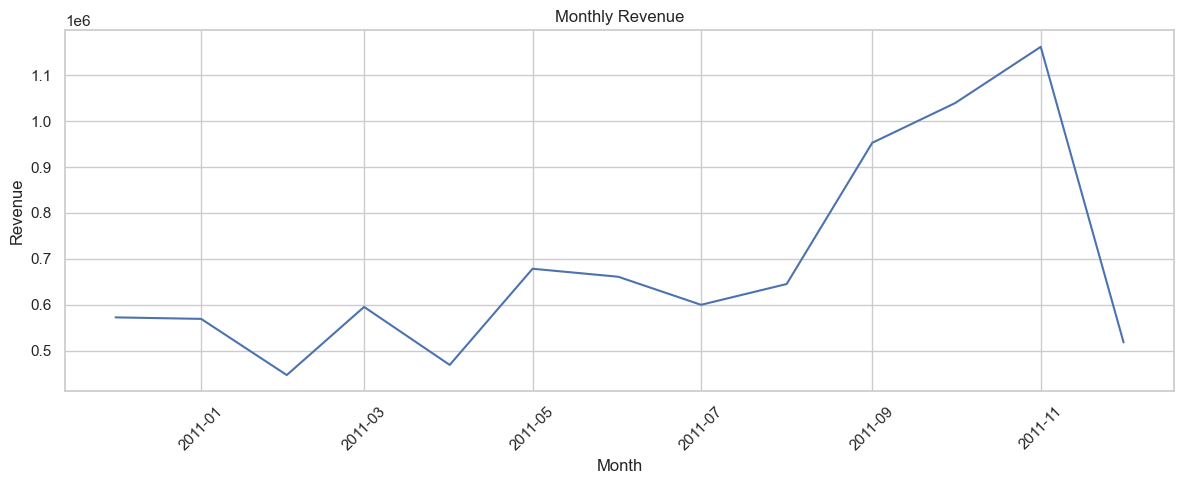

In [9]:
# 5) Monthly sales time series
if 'InvoiceMonth_dt' in df.columns:
    monthly = df.groupby('InvoiceMonth_dt')['TotalPrice'].sum().sort_index()
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(monthly.index, monthly.values)
    ax.set_title('Monthly Revenue')
    ax.set_ylabel('Revenue')
    ax.set_xlabel('Month')
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('InvoiceMonth_dt not found.')


In [10]:
# 6) Customer-level metrics: orders per customer and LTV (revenue per customer)
if 'CustomerID' in df.columns:
    orders_per_customer = df.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False).head(10)
    revenue_per_customer = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
    display(orders_per_customer.reset_index().rename(columns={'InvoiceNo':'OrdersCount'}))
    display(revenue_per_customer.reset_index().rename(columns={'TotalPrice':'Revenue'}))


,CustomerID,OrdersCount
0,12748.0,210
1,14911.0,201
2,17841.0,124
3,13089.0,97
4,14606.0,93
5,15311.0,91
6,12971.0,86
7,14646.0,74
8,16029.0,63
9,13408.0,62


,CustomerID,Revenue
0,14646.0,280206.02
1,18102.0,259657.30
2,17450.0,194550.79
3,16446.0,168472.50
4,14911.0,143825.06
5,12415.0,124914.53
6,14156.0,117379.63
7,17511.0,91062.38
8,16029.0,81024.84
9,12346.0,77183.60


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.366,0.323,0.384,0.363,0.398,0.363,0.349,0.354,0.395,0.374,0.503,0.266
2011-01,1.0,0.221,0.266,0.230,0.321,0.288,0.247,0.242,0.300,0.326,0.365,0.118,NaN
2011-02,1.0,0.187,0.187,0.284,0.271,0.247,0.253,0.279,0.247,0.305,0.068,NaN,NaN
2011-03,1.0,0.150,0.252,0.199,0.223,0.168,0.268,0.230,0.279,0.086,NaN,NaN,NaN
2011-04,1.0,0.213,0.203,0.210,0.197,0.227,0.217,0.260,0.073,NaN,NaN,NaN,NaN
2011-05,1.0,0.190,0.173,0.173,0.208,0.232,0.264,0.095,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.174,0.157,0.264,0.231,0.335,0.095,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.181,0.207,0.223,0.271,0.112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.207,0.249,0.243,0.124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


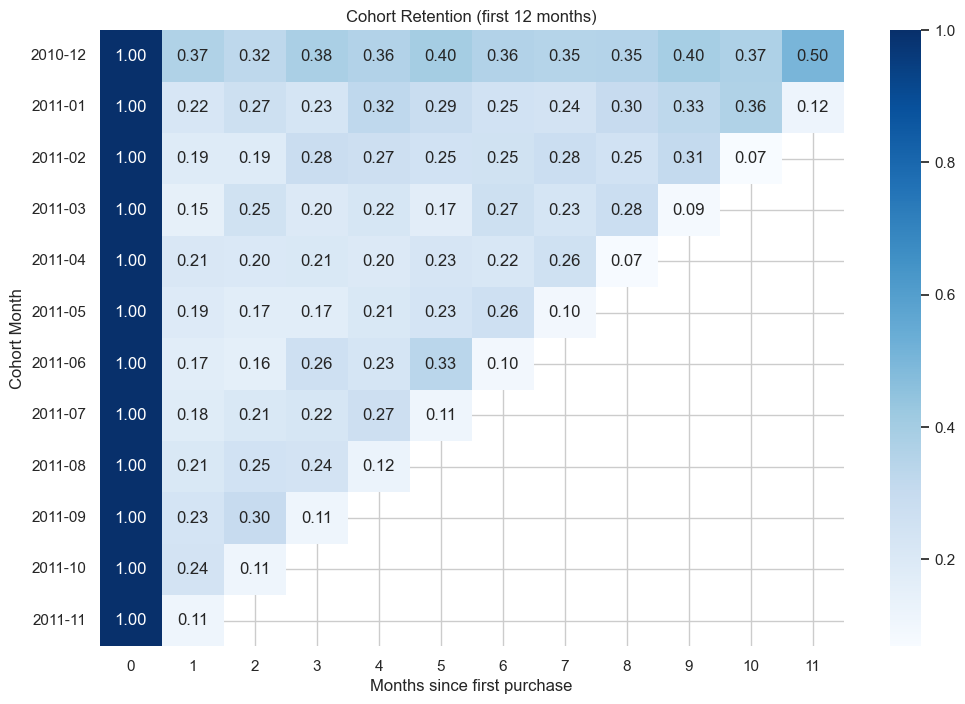

In [11]:
# 7) Cohort analysis (cohort by first purchase month)
# This creates a cohort table showing monthly retention (percentage of customers active in subsequent months).
if {'CustomerID','InvoiceDate'}.issubset(df.columns):
    df['InvoicePeriod'] = df['InvoiceDate'].dt.to_period('M')
    # Determine customer's first purchase month
    cohort = df.groupby('CustomerID')['InvoiceDate'].min().dt.to_period('M').reset_index()
    cohort.columns = ['CustomerID','CohortMonth']
    df = df.merge(cohort, on='CustomerID')

    # Calculate period number (months since cohort)
    df['CohortIndex'] = (df['InvoiceDate'].dt.to_period('M').astype(int) - df['CohortMonth'].astype(int))

    cohort_data = df.groupby(['CohortMonth','CohortIndex'])['CustomerID'].nunique().reset_index()
    cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

    # Normalize by cohort size to get retention rates
    cohort_size = cohort_pivot.iloc[:,0]
    retention = cohort_pivot.divide(cohort_size, axis=0)
    
    display(retention.round(3).head(12))
    
    # Heatmap
    plt.figure(figsize=(12,8))
    sns.heatmap(retention.iloc[:12,:12], annot=True, fmt='.2f', cmap='Blues')
    plt.title('Cohort Retention (first 12 months)')
    plt.ylabel('Cohort Month')
    plt.xlabel('Months since first purchase')
    plt.show()
else:
    print('Cohort analysis requires CustomerID and InvoiceDate columns.')


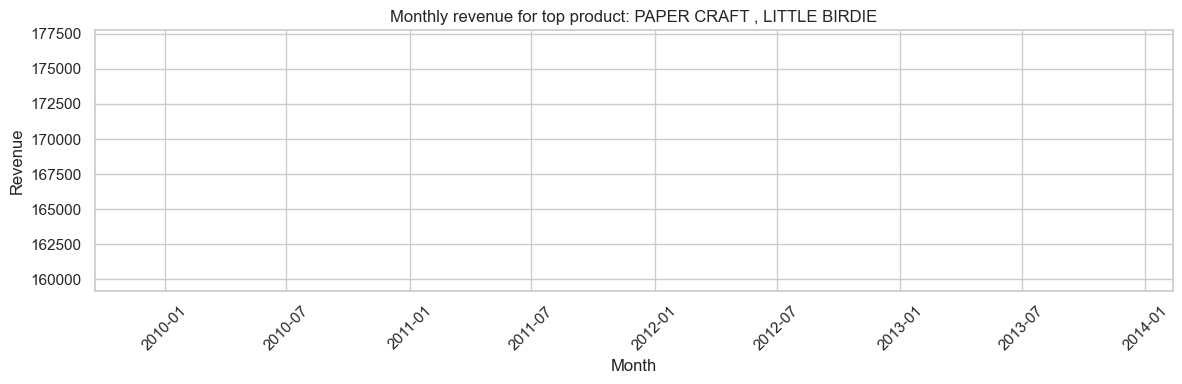

In [13]:
# 8) Top product seasonality example (pick top product and show monthly sales)
if 'Description' in df.columns and 'InvoiceMonth_dt' in df.columns:
    top_product = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).index[0]
    top_df = df[df['Description'] == top_product].groupby('InvoiceMonth_dt')['TotalPrice'].sum().sort_index()
    plt.figure(figsize=(12,4))
    plt.plot(top_df.index, top_df.values)
    plt.title(f'Monthly revenue for top product: {top_product[:60]}')
    plt.xlabel('Month')
    plt.ylabel('Revenue')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('Required columns for seasonality check not found.')


In [ ]:
## Conclusions & Recommendations

"
"- Identify top product categories and allocate inventory and promotions accordingly.
"
"- Target high-LTV customers with retention campaigns and personalized offers.
"
"- Investigate countries/regions with high revenue but low repeat purchase rates.
"
"- Use cohort retention insights to improve onboarding and early engagement.
"


In [ ]:
# (Optional) Save key outputs for dashboard or GitHub
# Uncomment and run to export summary tables
# monthly.to_csv('monthly_revenue.csv', index=True)
# prod_rev.to_csv('top_products_revenue.csv')
# revenue_per_customer.to_csv('top_customers_revenue.csv')
print('If you want to export tables, uncomment the save lines.')


In [ ]:
### Resume / GitHub README snippet

"
"**Project:** Online Retail — Sales Analysis  
"
"**Description:** Exploratory analysis of a large e-commerce dataset. Data cleaning, descriptive statistics, time-series analysis, customer metrics (LTV, orders per customer), cohort retention analysis, and visualizations.  
"
"**Tools:** Python (pandas, numpy, matplotlib, seaborn), SQL (demonstrated examples possible), Power BI (recommended for dashboard).  
"
"**Outcome:** Identified top revenue-generating products and customer retention patterns; prepared recommendations for marketing and inventory planning. 
"